In [1]:
#package imports

import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import datasets
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
training_data = pd.read_json("train.json")
test_data = pd.read_json("test.json")

In [3]:
# Find time and day of week
def split_day_hour(df):
    weekday = []
    req_hour = []

    for i in df['unix_timestamp_of_request']:
        dt = datetime.datetime.fromtimestamp(i)
        weekday.append(dt.date().weekday())
        req_hour.append(dt.time().hour)
    
    return weekday, req_hour

In [4]:
tr_day, tr_hour = split_day_hour(training_data)
test_day, test_hour = split_day_hour(test_data)

training_data['weekday'] = tr_day
training_data['req_hour'] = tr_hour
test_data['weekday'] = test_day
test_data['req_hour'] = test_hour

In [5]:
# Separate success/fail sets
pizza = training_data[training_data['requester_received_pizza'] == True]
no_pizza = training_data[training_data['requester_received_pizza'] == False]
no_pizza_short = no_pizza[:len(pizza)]

# Create new dataframe with equal outcomes
new_train = pd.concat([pizza, no_pizza_short], axis = 0)
new_train = new_train.sample(frac=1) # shuffle
new_train.reset_index()
new_train['requester_received_pizza'] = new_train['requester_received_pizza'].astype(int) # boolean to 0/1

# Split data and set the appropriate columns
test_features = test_data.columns
Y = new_train['requester_received_pizza']
X = new_train[training_data.columns[training_data.columns.isin(test_features)]]

# Split for train and validation
val_split = int(len(new_train) * 0.9)
train_data, train_labels = X[:val_split], Y[:val_split]
val_data, val_labels = X[val_split:], Y[val_split:]


# Get only request text
train_requests = train_data['request_text_edit_aware'].str.lower().tolist()
val_requests = val_data['request_text_edit_aware'].str.lower().tolist()

## Data pre-processing

In [6]:
# Append request length
def req_length(data):
    req_lens = []
    for request in data['request_text_edit_aware']:
        req_lens.append(len(request.split()))
    
    data['req_len'] = req_lens
    
    return data

In [7]:
# Append title length
def title_length(data):
    title_lens = []
    for title in data['request_title']:
        title_lens.append(len(title.split()))
    
    data['title_len'] = title_lens
    
    return data

In [8]:
money = ['money',
        'rent',
        'broke',
        'paid',
        'spent',
        'bills',
        'paycheck',
        'payment',
        'struggle',
        'landlord',
        'debt',
        'unexpected',
        'dollars',
        'budget',
        'stamps',
        'check',
        'month',
        'week',
        'mon',
        'tues',
        'wed',
        'thurs',
        'fri',
        'accident',
        'car',
        'hospital',
        'medical',
        ]

hunger = ['food',
        'hungry',
        'starving',
        'starve',
        'empty',
        'ramen',
        'nothing',
        'eaten',
        'belly',
        'stomach',
        'fridge',
        'cupboard',
        'leftovers',
        'groceries',
        'pantry',
        'meal']

unemployed = ['job',
            'work',
            'unemployed',
            'laid off',
            'fired',
            'grad',
            'interview',
            'application']

gratitude = ['thank',
            'kind',
            'pay it forward',
            'give back',
            'sincere',
            'promise',
            'thanks',
            'help',
            'great',
            'hey']

word_bags = {'money': money, 
             'hunger': hunger, 
             'unemployed': unemployed,
             'thanks': gratitude}

In [9]:
def encode_one_hot(text, data):
    one_hot = []
    requests = data['request_text_edit_aware'].str.lower().tolist()
    
    for i in range(len(data)):
        check = []

        for word in text:
            if word in requests[i]:
                check.append(True)
                break
            else:
                check.append(False)
            
        if any(check):
            one_hot.append(1)
        else:
            one_hot.append(0)

    
    return one_hot

In [10]:
def add_one_hots(bags, df):
    for bag in bags:
        col_name = bag
        bag_one_hots = encode_one_hot(bags[col_name], df)
        df[col_name] = bag_one_hots
    
    return df

In [11]:
# Add the new features
train_data = req_length(train_data)
train_data = title_length(train_data)
train_data = add_one_hots(word_bags, train_data)


val_data = req_length(val_data)
val_data = title_length(val_data)
val_data = add_one_hots(word_bags, val_data)

In [12]:
train_data.head()

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,unix_timestamp_of_request,unix_timestamp_of_request_utc,weekday,req_hour,req_len,title_len,money,hunger,unemployed,thanks
4004,N/A,t3_j06yw,"hey there,\nfirst time poster, long time lurke...","[request] broken shoulder, out of work, very h...",0.000000,0.000000,0,0,0,0,...,1311695473,1311691873,1,8,59,8,1,1,1,1
2267,N/A,t3_hxvb6,I am an unemployed musician in Tennessee who c...,[Request] Unemployed musician hosting touring ...,66.525347,4.649514,86,1,4,0,...,1307903987,1307900387,6,11,119,16,1,1,1,1
1088,N/A,t3_1ewe42,I do have a couple XBOX games I dont play an...,"[REQ] Oh powerful pizza Gods, bestow upon me y...",260.085764,99.605567,437,1,34,0,...,1369316143,1369312543,3,6,17,20,0,0,0,0
1262,N/A,t3_1m28mz,Have a few hours to kill before I walk to work...,[REQUEST] Food before work.,481.852731,0.000000,224,0,16,0,...,1378767159,1378763559,0,15,51,4,1,0,1,1
2235,N/A,t3_1hu814,"I get paid in a week, so I've got rice and bea...","[Request] Denton, TX USA",140.916736,0.000000,4,0,0,0,...,1373255076,1373251476,6,20,49,4,1,1,0,1


In [13]:
# Use only specific features
tree_features = ['requester_account_age_in_days_at_request',
                'requester_number_of_comments_in_raop_at_request',
                'requester_upvotes_plus_downvotes_at_request',
                'weekday',
                'req_hour',
                'req_length',
                'title_length'
                'money',
                'hungry',
                'thanks',
                'job']

tr_train = train_data[train_data.columns[train_data.columns.isin(tree_features)]]
tr_val = val_data[val_data.columns[val_data.columns.isin(tree_features)]]

Using a decision stump -- a tree with depth 3:
Feature importances: [0.11927803 0.32807152 0.31991463 0.         0.         0.23273582]
Validation Accuracy: 0.5778894472361809


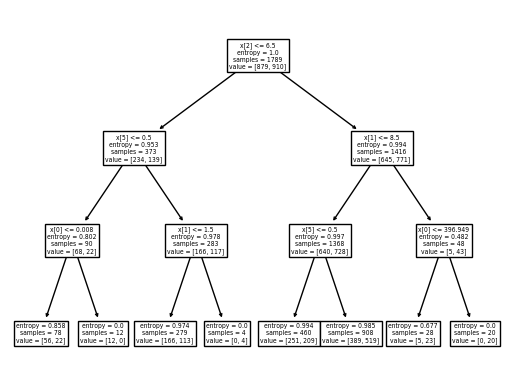

In [14]:
# Set classifier and fit for decision tree
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dt.fit(tr_train, train_labels)
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 3:')
print ('Feature importances:', dt.feature_importances_)
print ('Validation Accuracy:', dt.score(tr_val, val_labels))

In [15]:
forest = RandomForestClassifier(n_estimators = 100)

forest.fit(tr_train, train_labels)

print ('Training Accuracy:', forest.score(tr_train, train_labels))
print ('Validation Accuracy:', forest.score(tr_val, val_labels))

Training Accuracy: 0.9675796534376747
Validation Accuracy: 0.5226130653266332


In [16]:
rf_val_predictions = forest.predict(tr_val)

pd.DataFrame(confusion_matrix(val_labels, rf_val_predictions))

,0,1
0,55,60
1,35,49


In [17]:
print(classification_report(val_labels, rf_val_predictions))

              precision    recall  f1-score   support

           0       0.61      0.48      0.54       115
           1       0.45      0.58      0.51        84

    accuracy                           0.52       199
   macro avg       0.53      0.53      0.52       199
weighted avg       0.54      0.52      0.52       199



In [18]:
# Check requests for correct vs. incorrect predictions
val_labels[:10]

1728    1
930     0
550     0
60      1
865     0
144     0
2482    1
1307    0
359     0
1289    1
Name: requester_received_pizza, dtype: int64

In [19]:
rf_val_predictions[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0])

In [20]:
val_data[:10]

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,unix_timestamp_of_request,unix_timestamp_of_request_utc,weekday,req_hour,req_len,title_len,money,hunger,unemployed,thanks
1728,N/A,t3_jtbys,[Request] Out of Saint Louis Missouri. (Specif...,[Request] I have been having shit luck... Pizz...,643.993484,0.000000,106,0,10,0,...,1314226481,1314222881,2,15,570,11,1,1,1,1
930,N/A,t3_10d5w8,I've been without a job since the middle of Au...,"[Request] A pizza today, I'll pizza you at a l...",163.086551,0.000000,0,0,46,0,...,1348447622,1348444022,6,17,142,13,1,1,1,1
550,N/A,t3_1fxkzy,"Hi RAOP.\nI'm starving, I could seriously need...",[Request] Just paid back my roommate for payin...,518.963704,409.984178,312,0,66,1,...,1370713427,1370709827,5,10,16,18,0,1,0,0
60,N/A,t3_1ndzxb,"Title pretty much says it all, would love a pi...",[Request] Broke college student who just ate h...,491.068750,0.000000,981,0,26,0,...,1380508521,1380479721,6,19,18,14,1,0,0,0
865,N/A,t3_1icpql,"I've nothing I can sell, not even my own blood...","(Request) Ohio, I'll spare the sob story. Life...",481.633484,0.000000,41,0,13,0,...,1373914279,1373910679,0,11,59,21,1,1,1,1
144,N/A,t3_17i74u,yep. like i said....im broke and dont have muc...,"[Request] Pennsylvania, Im broke, no class tod...",388.772674,46.859097,315,5,59,0,...,1359480713,1359480713,1,9,59,19,1,0,0,1
2482,N/A,t3_huz3x,"That's about it, I suppose. My wife fortunatel...",[Request] Laid off for a few months now. Not s...,596.717870,0.000000,0,0,352,0,...,1307572894,1307569294,2,15,21,25,0,0,0,0
1307,N/A,t3_wsinb,It's my friends IRL cakeday and he is home alo...,[Request]. Pizza for friends cake day IRL,112.976829,0.000000,41,0,24,0,...,1342663240,1342659640,2,19,31,7,1,0,0,0
359,N/A,t3_izi35,I just brought pizza to a friend who has gone ...,(request) Pizza for psychiatric inpatients,217.113380,0.000000,63,0,14,0,...,1311629545,1311625945,0,14,74,5,1,0,0,0
1289,N/A,t3_1mjg9b,I just moved into a new house this week. And n...,[Request] used this sub last time I moved into...,578.272338,467.064780,753,4,102,2,...,1379381929,1379378329,0,18,30,19,1,1,0,1


In [21]:
val_requests[:10]

["[request] out of saint louis missouri. (specifically the soulard area)\n\nso here is my story, hopefully it will warrant delicious pizza..\n\nfor the past 5 months i have been an addict in recovery.\nat one point i realized i no longer wanted to keep living the way i was living.. talked to my family and got help. i was addicted to amphetamines and was starting to develop a bad heroin habit. i spend 42 days in rehab.. came out with a new lease on life, and spent the next 3 - 4 months in a sober living facility. just trying to remember how to live and enjoy life sober.. i got the best job i have ever had (contracting for charter) and after a month i was promoted to be the south saint louis market contractor. (basically i managed all southern saint louis contractors)\nthings were going great, with my new job i rented out a new apartment set myself up a home office, and genuinely enjoyed day to day activities. then one day, when i was heading back from a narcotics anonymous meeting, i go

## Test predictions

In [22]:
test_data = req_length(test_data)
test_data = title_length(test_data)
test_data = add_one_hots(word_bags, test_data)
tr_test = test_data[test_data.columns[test_data.columns.isin(tree_features)]]

In [23]:
# tree predictions
#test_predictions = dt.predict(tr_test)
rf_test_predictions = forest.predict(tr_test)

In [24]:
def get_submission_csv(predictions):
    test_ids = test_data['request_id']
    
    d = {'request_id': test_ids,
    'requester_received_pizza': predictions}
    
    df = pd.DataFrame(data=d)
    df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)
    
    return df

In [25]:
df = get_submission_csv(rf_test_predictions)

In [26]:
df.to_csv('rf_model.csv', index=False)